# Домашнее задание 3

## Блок 1. Введение

В этом небольшом домашнем задании мы потренируемся работать с SARIMA-моделью. Для начала про данные. В этот раз они недельные. Будем прогнозировать на небольшой горизонт, 4 недели.

* target -- средневзвешенная по портам стоимость аммиака (usd/tonn) в некотором европейском регионе. Аммиак -- один из основных компонентов для производства азотных удобрений.
* oil -- стоимость фьючерса на нефть марки BRENT (usd)
* gas -- стоимость фьючерса на природный газ (usd)
* coal -- стоимость фьючерса на уголь (usd)
* corn, soybean, wheat, rice -- стоимость кукурузы, сои, пшеницы и риса соответственно (usd)

* usd_eur, usd_rub, usd_jpy, usd_cny -- курсы евро, рубля, йены и юаня к доллару
* usd_index -- индекс доллара

* cpy_us, cpi_china -- ВВП США и Китая


In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

from sktime.utils.plotting import plot_correlations
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV, temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon

import statsmodels.api as sm

### 1.1) Загрузка данных. (0.5 балла)

Загрузите данные из файла data.csv. Сконвертируйте индексы в формат datetime. Обратите внимание на формат даты. При дефолтных параметрах конвертация произойдёт неверно. Далее используйте метод to_period, чтобы сконвертировать индексы, иначе ARIMA упадёт. В этот раз не будем разбивать на трейн и тест, а просто пройдёмся кросс-валидацией по всей выборке.



In [2]:
# ༼ つ ◕_◕ ༽つ
import pandas as pd
data = pd.read_csv('data.csv')
data.sample(5)

,date,target,oil,gas,coal,corn,soybean,wheat,rice,usd_eur,usd_jpy,usd_cny,usd_index,usd_rub,cpi_china,cpi_us
244,05/01/1992,NaN,18.12,1.299,NaN,NaN,NaN,NaN,NaN,0.7418,124.67,5.4559,85.630,NaN,NaN,138.300
1124,16/11/2008,250.0,54.24,6.312,95.75,151.941363,345.385068,191.06408,333.009987,0.7948,96.94,6.8243,86.785,27.3730,84.123852,213.153
98,19/03/1989,NaN,17.76,NaN,NaN,NaN,NaN,NaN,NaN,0.8951,131.68,3.7314,97.380,NaN,NaN,122.200
469,28/04/1996,NaN,19.80,2.207,NaN,NaN,NaN,NaN,NaN,0.7989,105.45,8.3300,87.830,4.9500,70.215949,156.100
1719,12/04/2020,222.0,31.48,1.733,63.60,131.400000,317.200000,204.40000,320.100000,0.9144,108.47,7.0360,99.504,73.7523,111.300000,255.902


In [3]:
data.index = pd.to_datetime(data.date,dayfirst=True).dt.to_period('W')

In [4]:
data.sample(5)

,date,target,oil,gas,coal,corn,soybean,wheat,rice,usd_eur,usd_jpy,usd_cny,usd_index,usd_rub,cpi_china,cpi_us
date,,,,,,,,,,,,,,,,
1997-01-20/1997-01-26,26/01/1997,NaN,22.26,2.824,NaN,NaN,NaN,NaN,NaN,0.8355,118.93,8.2951,92.050,5.6250,71.726763,159.400
2013-01-14/2013-01-20,20/01/2013,593.0,111.89,3.566,93.25,286.846276,536.357290,281.819518,332.017902,0.7510,90.08,6.2154,80.116,30.2670,96.188552,231.679
2009-05-18/2009-05-24,24/05/2009,213.0,60.78,3.515,75.92,166.996830,421.259553,216.967960,264.335633,0.7146,94.78,6.8232,80.055,31.0660,84.035292,213.022
2003-04-21/2003-04-27,27/04/2003,153.0,24.09,5.477,NaN,NaN,NaN,NaN,NaN,0.9062,120.21,8.2770,98.620,31.1090,71.388853,183.200
2016-02-08/2016-02-14,14/02/2016,255.0,33.36,1.966,50.70,143.522187,316.909171,168.467078,240.746048,0.8881,113.22,6.5739,95.982,78.3558,102.700000,237.469


## 1.2) Визуальный анализ. (1 балл)
Изобразите временной ряд, его автокорреляции и частные автокорреляции. Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Стационарность?

In [5]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
plt.style.use('ggplot')

In [6]:
data

,date,target,oil,gas,coal,corn,soybean,wheat,rice,usd_eur,usd_jpy,usd_cny,usd_index,usd_rub,cpi_china,cpi_us
date,,,,,,,,,,,,,,,,
1987-04-27/1987-05-03,03/05/1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.000
1987-05-04/1987-05-10,10/05/1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8559,139.73,3.7314,96.100,NaN,NaN,113.000
1987-05-11/1987-05-17,17/05/1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8501,139.58,3.7314,95.620,NaN,NaN,113.000
1987-05-18/1987-05-24,24/05/1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8513,140.83,3.7314,96.030,NaN,NaN,113.000
1987-05-25/1987-05-31,31/05/1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8700,143.88,3.7314,97.890,NaN,NaN,113.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23/2020-11-29,29/11/2020,213.5,48.18,2.843,63.90,168.779715,439.814815,224.867725,273.484865,0.8358,104.10,6.5769,91.801,75.8605,110.7,260.817
2020-11-30/2020-12-06,06/12/2020,213.5,49.25,2.575,74.25,166.006339,424.015285,210.537919,273.595097,0.8248,104.14,6.5316,90.694,74.0634,111.5,261.775
2020-12-07/2020-12-13,13/12/2020,215.5,49.97,2.591,77.70,167.194929,425.852440,216.784245,272.823475,0.8254,104.01,6.5463,90.970,72.9572,111.5,261.775


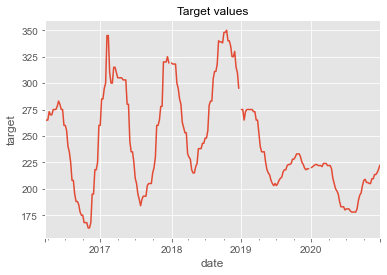

In [7]:
# ༼ つ ◕_◕ ༽つ
fig,ax = plt.subplots()
sns.set(rc={'figure.figsize':(15,15)})
data.target[-250:].plot()
ax.set_xlabel('date')
ax.set_ylabel('target')
ax.set_title('Target values');

In [8]:
from sktime.utils.plotting import plot_correlations

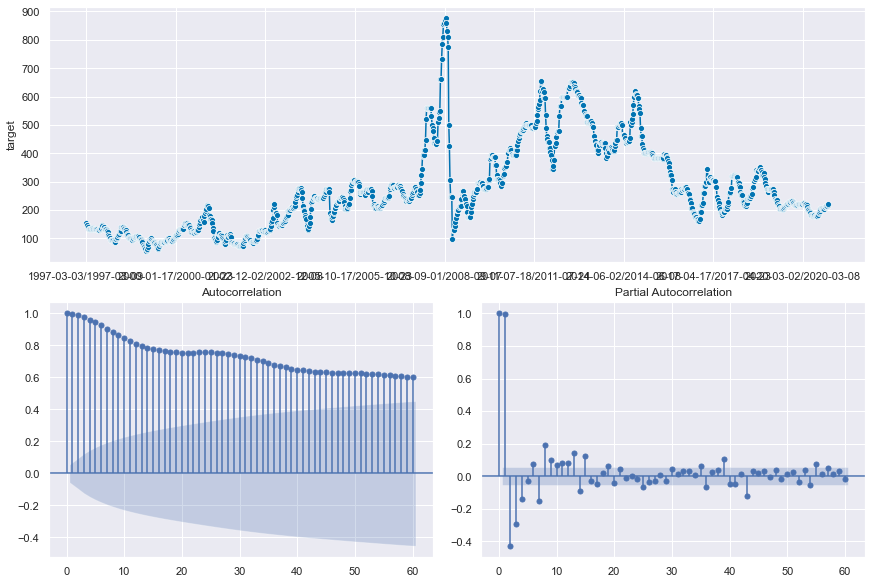

In [9]:
plot_correlations(data.target.interpolate().dropna(), lags=60);

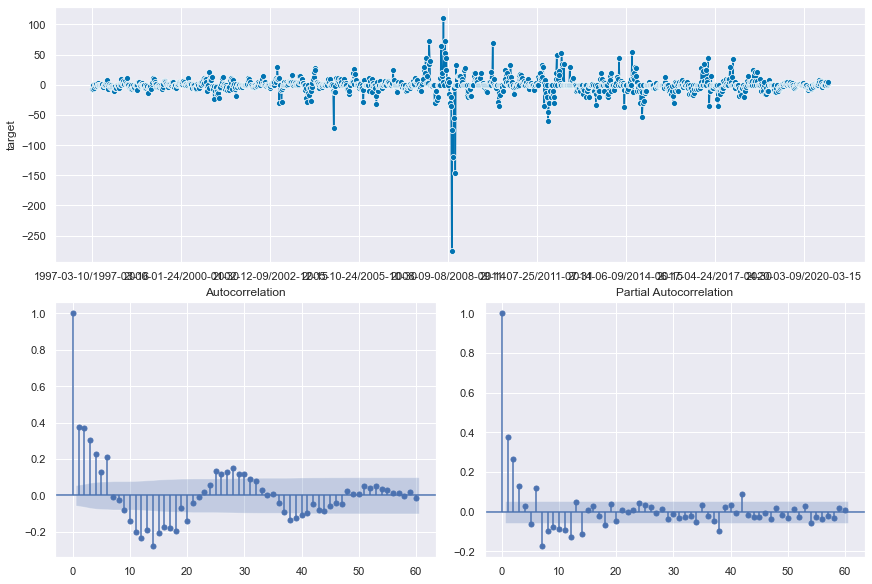

In [10]:
plot_correlations(data.target.interpolate().diff().dropna(), lags=60);

Пристутствует слабовозрастающий тренд, есть сезонность(предположительно, квартальная), и цикличность, ряд не стационарен.

## Блок 2. SARIMA

Сначала попробуем прогнозировать без внешних переменных.

### 2.1) Стационарность (1 балл)

Сначала примените сглаживающее преобразование (например, Бока-Кокса, или иное по своему усмотрению), если необходимо. 

Определите параметры d и D. Для этого воспользуйтесь STL-разложением и KPSS-тестом.

Детрендируйте ряд согласно параметрам d и D.

In [11]:
import numpy as np
from scipy.stats import boxcox
boxcox_transformed_data = boxcox(data.target.interpolate().dropna())

In [12]:
from statsmodels.tsa.stattools import kpss

In [13]:
train = boxcox_transformed_data[0]

In [14]:
kpss(train)

C:\Users\Asus\anaconda4\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Asus\anaconda4\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(2.7332883616850667,
 0.01,
 23,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

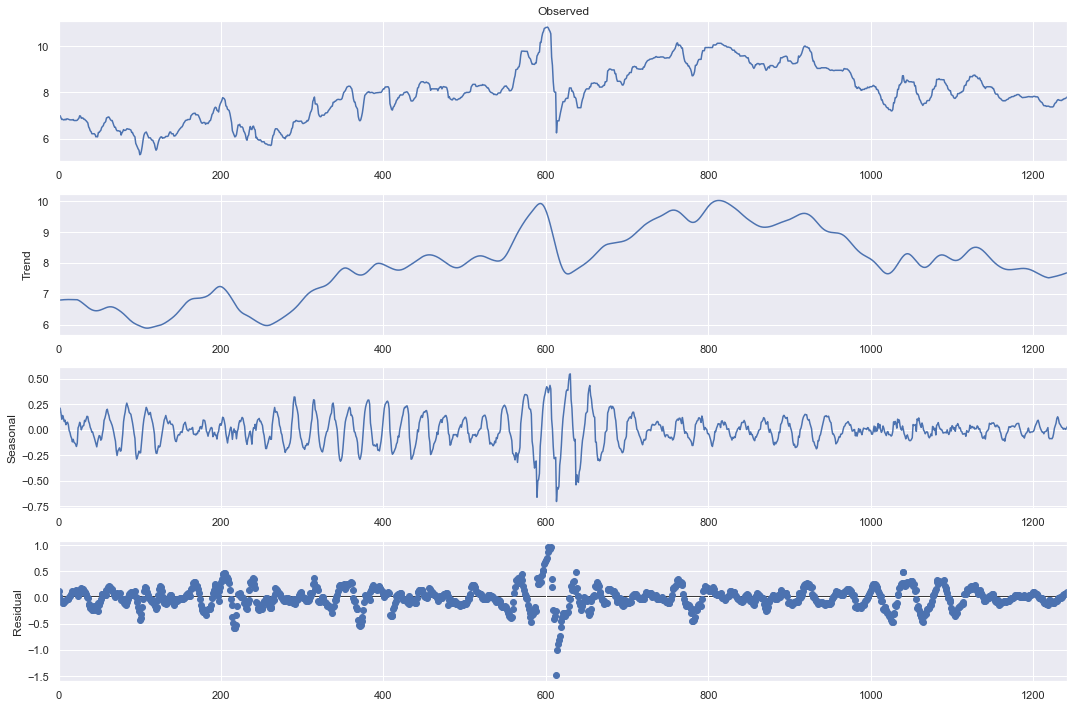

In [15]:
from statsmodels.tsa.seasonal import STL

plt.rcParams["figure.figsize"] = (15,10)

stl = STL(train, period=24)
res = stl.fit()
res.plot();

plt.rcParams["figure.figsize"] = (23,9)

In [16]:
seas_strength = max(0, 1 - res.resid.std()**2 / (res.resid.std()**2 + res.seasonal.std()**2))

seas_strength

0.3441994896300419

значение силы сезонности меньше 0.65

Значит D = 0

In [17]:
df = pd.DataFrame({'target':train},index=data.target.interpolate().dropna().index)

In [18]:
target_diff = df.target.diff().dropna()

In [19]:
kpss(target_diff)

C:\Users\Asus\anaconda4\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Asus\anaconda4\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.05817988091152099,
 0.1,
 23,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Тестовая статистика меньше 0.463, поэтому гипотеза о стационарности не отвергается

Значит d = 1

### 2.2) Анализ коррелограмм (1 балл)

Определите период сезонности, если она предполагается. Предположите, в каких границах лежат параметры p, q, P, Q. Для этого используйте коррелограммы.

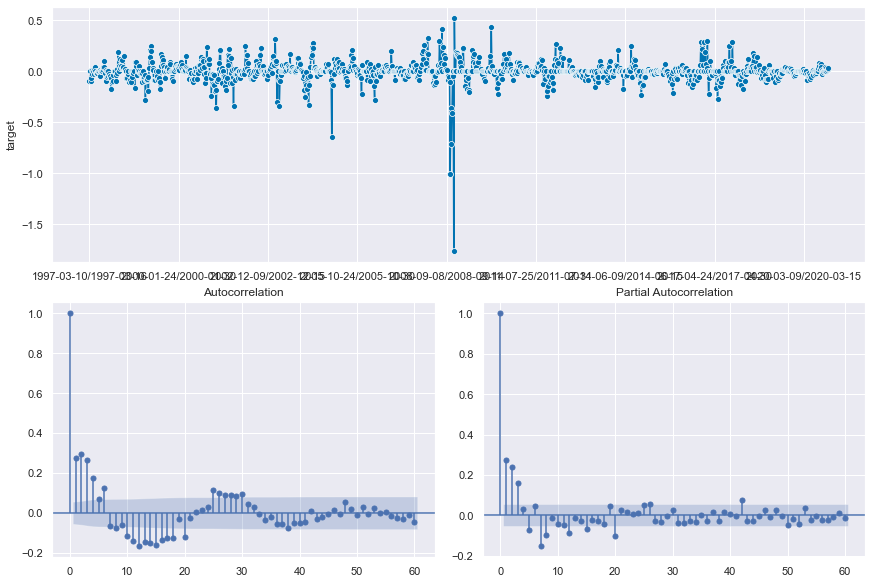

In [20]:
# ༼ つ ◕_◕ ༽つ
plot_correlations(target_diff, lags=60);

$ p \leq 3$

$ q \leq 4$

$ P \leq 2$ (не очень понятно по графику, вероятно небольшое)

$Q \leq 2 $

### 2.3) Кросс-валидация (0.5 балла)

Сгенерируйте сетку параметров. Отберите на кросс-валидации наилучшую модель. Используйте метод скользящего окна. Ширина окна 150 (~3 года). Шаг -- 4 недели. Если получается слишком долго, возьмите шаг побольше, 10-15. Длина тестового периода -- 4 недели. Метрика -- MAE.

In [21]:
# ༼ つ ◕_◕ ༽つ
d, max_p, max_q, D, max_P, max_Q = 1, 3, 4, 0, 2, 2
orders = []
sp = 24
for p in range(max_p+1):
    for q in range(max_q+1):
        orders.append((p, d, q))

seasonal_orders = []

for P in range(max_P+1):
    for Q in range(max_Q+1):
        seasonal_orders.append((P, D, Q, sp))

In [22]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError as MAE
from sktime.forecasting.model_selection import SlidingWindowSplitter
mae = MAE()

In [23]:
fh = ForecastingHorizon(list(range(1, 4+1)))

cv = SlidingWindowSplitter(
    start_with_window=True,
    initial_window=150,
    fh=fh,
    step_length=15)

In [122]:
forecaster = ARIMA()
param_grid = {"order" : orders, "seasonal_order":seasonal_orders}
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv, n_jobs=-1,scoring = mae,verbose=1)
gscv.fit(train)

Fitting 73 folds for each of 180 candidates, totalling 13140 fits


ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4], dtype='int64', is_relative=True),
           initial_window=150, step_length=15),
                        forecaster=ARIMA(), n_jobs=-1,
                        param_grid={'order': [(0, 1, 0), (0, 1, 1), (0, 1, 2),
                                              (0, 1, 3), (0, 1, 4), (1, 1, 0),
                                              (1, 1, 1), (1, 1, 2), (1, 1, 3),
                                              (1, 1, 4), (2, 1, 0), (2, 1, 1),
                                              (2, 1, 2), (2, 1, 3), (2, 1, 4),
                                              (3, 1, 0), (3, 1, 1), (3, 1, 2),
                                              (3, 1, 3), (3, 1, 4)],
                                    'seasonal_order': [(0, 0, 0, 24),
                                                       (0, 0, 1, 24),
                                                       (0, 0, 2, 24),
                         

In [123]:
gscv.best_forecaster_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 1243
Model:             SARIMAX(0, 1, 0)x(2, 0, [1, 2], 24)   Log Likelihood                1045.166
Date:                                 Fri, 15 Apr 2022   AIC                          -2078.332
Time:                                         20:10:16   BIC                          -2047.585
Sample:                                              0   HQIC                         -2066.769
                                                - 1243                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.004      0.145      0.885      -0.008       0.009
ar.S.L24       0.2200      0.683      0.322      0.747      -1.119       1.559
ar.S.L48      -0.2895      0.710     -0.407      0.684      -1.682       1.103
ma.S.L24      -0.1912      0.678     -0.282      0.778      -1.521       1.138
ma.S.L48       0.3391      0.685      0.495      0.621      -1.004       1.682
sigma2         0.0109      0.000     99.032      0.000       0.011       0.011
===================================================================================
Ljung-Box (L1) (Q):                  92.41   Jarque-Bera (JB):            308833.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -4.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        79.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
from tqdm.auto import tqdm

### 2.4 Сравнение (0.5 балла)

Сравните ошибку на кросс-валидации для вашей модели, наивной модели и AutoARIMA. Не забудьте проверить, что границы поиска параметров AutoARIMA не меньше ваших. Получилось ли переиграть две последние модели? Совпали ли отобранная вами модель и модель из AutoARIMA?


In [25]:
res = []
for idx in tqdm(list(cv.split(df))):
    y_train = df.iloc[idx[0]]
    y_val = df.iloc[idx[1]]
    fh = ForecastingHorizon(list(range(1, 4+1)))
    model = ARIMA(order=(0, 1, 0),seasona_order = (2,0,1,12),suppress_warnings=True, maxiter=10**4).fit(y_train)
    pred = model.predict(fh)
    res.append(mae(y_val,pred))

  0%|          | 0/73 [00:00<?, ?it/s]

In [26]:
res_val = np.mean(res) 

In [27]:
res_val

0.14791587861959293

In [29]:
auto_arima = AutoARIMA(start_p=0, d=1, start_q=0, max_p=3, max_d=2, 
                       max_q=4, start_P=0, D=0, start_Q=0, max_P=2,
                       max_D=0, max_Q=2, max_order=5, sp=24)
auto_arima.fit(df)

In [145]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1243
Model:               SARIMAX(3, 1, 0)   Log Likelihood                1142.856
Date:                Fri, 15 Apr 2022   AIC                          -2277.712
Time:                        20:15:38   BIC                          -2257.214
Sample:                             0   HQIC                         -2270.004
                               - 1243                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1730      0.007     25.932      0.000       0.160       0.186
ar.L2          0.2039      0.013     15.537      0.000       0.178       0.230
ar.L3          0.1569      0.019      8.277      0.000       0.120       0.194
sigma2         0.0093   9.45e-05     98.356      0.000       0.009       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):            413155.82
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -4.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
res1 = []
for idx in list(cv.split(df)):
    y_train = df.iloc[idx[0]]
    y_val = df.iloc[idx[1]]
    fh = ForecastingHorizon(list(range(1, 4+1)))
    model = ARIMA(order=(3,1,0),suppress_warnings=True).fit(y_train)
    pred = model.predict(fh)
    res1.append(mae(y_val,pred))

In [31]:
res_auto = np.mean(res1) 
res_auto

0.16052459621234716

In [32]:
from sktime.forecasting.naive import NaiveForecaster
res2 = []
for idx in list(cv.split(df)):
    y_train = df.iloc[idx[0]]
    y_val = df.iloc[idx[1]]
    fh = ForecastingHorizon(list(range(1, 4+1)))
    model = NaiveForecaster('last',sp=1).fit(y_train)
    pred = model.predict(fh)
    res2.append(mae(y_val,pred))

In [33]:
res_naive = np.mean(res2)

In [34]:
print('Модель на кросс-валидации', res_val)
print('Модель AutoARIMA', res_auto)
print('Наивная модель', res_naive)

Модель на кросс-валидации 0.14791587861959293
Модель AutoARIMA 0.16052459621234716
Наивная модель 0.10527144564076812


Наивную модель побить не удалось. 

Отобранная модель и модель, полученная с помощью AutoARIMA, не совпали, что не удивительно, так как мы отбирали модель по MAE, тогда как AutoARIMA отбирает по AIC

## Блок 3. SARIMAX

Маленькое вступление. Теперь мы попытаемся добавить в модель внешние регрессоры. Вообще говоря, модель SARIMAX -- это попытка объединить в одной модели всё сразу, что, ожидаемо, редко приводит к хорошему и устойчивому результату. И, что самое главное, такую модель ещё сложнее настраивать. Более эффективным с практической точки зрения было бы построить отдельно модель на внешних переменных (в духе моделей машинного обучения), а с автокорреляциями в её остатках побороться уже SARMA-моделью, но в случае линейной регрессии особой разницы не будет.  Но мы всё же разберём этот подход, чтобы понимать его сложности.

Если коротко про достоинства и недостатки этой модели:

Плюсы:

* Весьма гибкая модель, позволяет учесть кучу особенностей в данных
* Может быть неплоха, если нам нужны только одношаговые прогнозы и у нас не очень много переменных

Минусы:

* Ещё сложнее настраивать, чем SARIMA
* Рекурсивна. Отсюда проблемы с многошаговым прогнозированием и накоплением ошибки
* При большом количестве экзогенных переменных и малом числе наблюдений может быть неустойчива

### 3.1) Выбор внешней переменной (1 балл)

Из всех внешних факторов выберите какую-нибудь переменную, которая будет удовлетворять тесту Гранжера. Кратко опишите причинно-следственную связь, которая может возникать между этими переменными. 

По дефолту в следующих пунктах в качестве фичи можете использовать первый лаг отобранной переменной. Если захотите взять ещё лаги, это конечно хорошо, но придётся аккуратно разбираться с прогнозом каждого лага, поэтому предлагается не усложнять себе жизнь.

In [35]:
df['y'] = df['target']

In [36]:
from statsmodels.tsa.stattools import grangercausalitytests

In [37]:
data.index = np.arange(len(data))

In [38]:
gas1 = data['gas'].iloc[data['gas'][~data['target'].isna()].index[0]-1:].shift(1).dropna()

In [39]:
# ༼ つ ◕_◕ ༽つ
df['gas1']=gas1.to_list()

In [40]:
_=grangercausalitytests(df[['y','gas1']],maxlag = [15])


Granger Causality
number of lags (no zero) 15
ssr based F test:         F=2.4940  , p=0.0012  , df_denom=1197, df_num=15
ssr based chi2 test:   chi2=38.3795 , p=0.0008  , df=15
likelihood ratio test: chi2=37.7919 , p=0.0010  , df=15
parameter F test:         F=2.4940  , p=0.0012  , df_denom=1197, df_num=15


In [41]:
_=grangercausalitytests(df[['gas1','y']],maxlag = [15])


Granger Causality
number of lags (no zero) 15
ssr based F test:         F=0.9201  , p=0.5410  , df_denom=1197, df_num=15
ssr based chi2 test:   chi2=14.1584 , p=0.5136  , df=15
likelihood ratio test: chi2=14.0774 , p=0.5197  , df=15
parameter F test:         F=0.9201  , p=0.5410  , df_denom=1197, df_num=15


Тест Гранжера  отвергает гипотезу о том, что цены на газ не влияют на цены на аммиак, и не отвергает гипотезу о том, что цены на аммиак не влияют на цены на газ.

Влияние цен на газ на цены на аммиак объясняются тем, что газ является основным сырьем для его производства.

### 3.2) Фильтрация (1.5 балла)

Использование внешней переменной несколько осложняет подбор параметров SARIMA. Дело в том, что если ряды y и x одинакового порядка интеграции, то при использовании их в одном уравнении тренды могут взаимно сократиться:

$$ y_t = SARIMA + \alpha_1 x_{t-1}$$

$$ y_t - \alpha_1 x_{t-1} = SARIMA $$

При некоторых обстоятельствах разница  $ y_t - \alpha_1 x_{t-1} $ может дать стациионарный ряд. В литературе такая ситуация называется коинтеграцией. Есть много не слишком внятных статей на эту тематику. Особенно туманны выводы для случаев, когда коинтеграции нет. Но в целом всё это скорее разговор о теоретических характеристиках оценок коэффициентов моделей. В контексте прогнозирования это обычно не учитывают и каких-то внятных рекомендаций тоже нет, либо они не распространены. Поэтому единственный адекватный способ узнать это влияние -- построить регрессию (либо SARIMA((0,0,0), (0,0,0)) с экзогенной переменной), а потом посмотреть, как устроены остатки, и на основе них сделать выводы о параметрах SARIMA. 

В большинстве случаев люди, конечно, так не заморачиваются. Берут AutoARIMA либо достаточно широкие границы на кросс-валидации и просто ждут. Но мы же учёные, нам так неинтересно!

Здесь уже видно, что в таком виде SARIMAX-модель банально аналогична тому, что мы оцениваем две модели: линрег, а на его остатки навешиваем SARIMA. Единственный плюс в том, что мы сможем это объединить в одном уравнении.


Собственно, задание: постройте SARIMAX((0,0,0), (0,0,0))  с выбранной экзогенной переменной (либо просто линрег y_t на x_{t-1}, будет то же самое). Будьте внимательны, дефолтный параметры класса ARIMA -- не совсем то, что мы просим. Далее получите остатки на трейне этой одношаговой модели.

In [42]:
df = sm.add_constant(df)

C:\Users\Asus\anaconda4\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [43]:
# ༼ つ ◕_◕ ༽つ
ols=sm.OLS(df['y'],df[['gas1','const']])
ols=ols.fit()

In [44]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     87.71
Date:                Sat, 16 Apr 2022   Prob (F-statistic):           3.44e-20
Time:                        09:51:41   Log-Likelihood:                -1896.6
No. Observations:                1243   AIC:                             3797.
Df Residuals:                    1241   BIC:                             3807.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
gas1           0.1325      0.014      9.366      0.000       0.105       0.160
const          7.4235      0.068    109.299      0.000       7.290       7.557
==============================================================================
Omnibus:                      128.280   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.126
Skew:                           0.164   Prob(JB):                     7.12e-10
Kurtosis:                       2.160   Cond. No.                         10.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
errors = df['y'] - ols.predict(df[['gas1','const']])

In [46]:
from sklearn.linear_model import LinearRegression

In [47]:
X = df['gas1'].to_numpy()
y = df['y'].to_numpy()

In [48]:
lr = LinearRegression()
lr.fit(X.reshape(-1,1),y)

LinearRegression()

In [49]:
lr.score(X.reshape(-1,1),y)

0.066013740837093

In [50]:
errors = y - lr.predict(X.reshape(-1,1))

### 3.3) Анализ остатков (1 балл)

Остатки из предыдущего пункта -- это по сути y, фильтрованный относительно выбранной экзогенной переменной. Сделайте выводы относительно параметров d и D, а также относительно границ параметров p, q, P, Q.

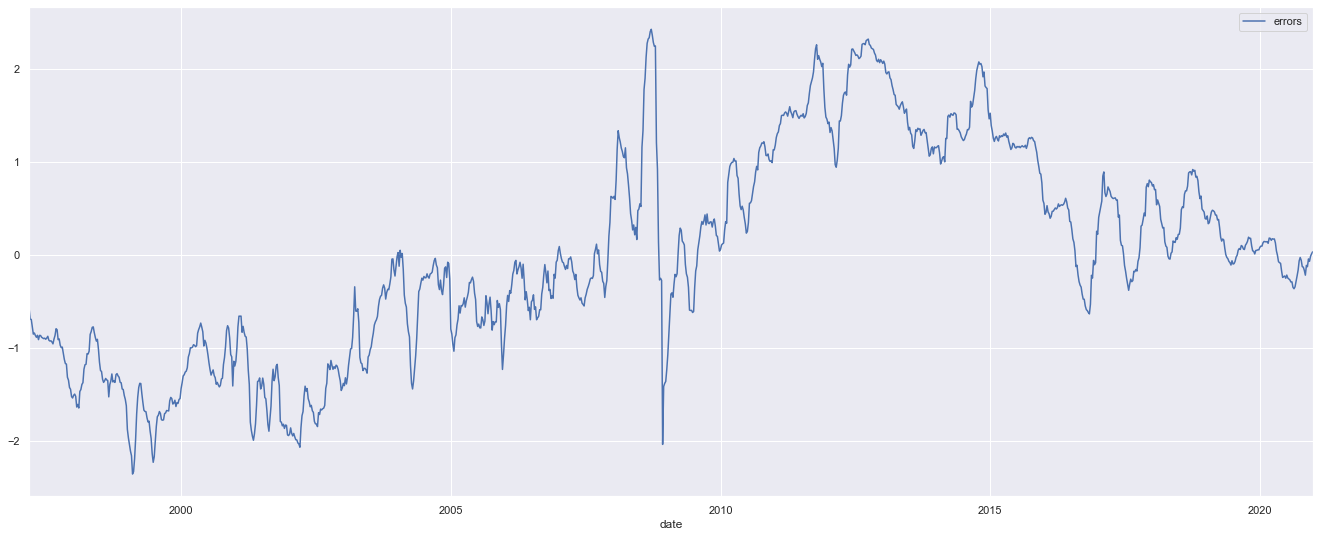

In [51]:
# ༼ つ ◕_◕ ༽つ
errors = pd.DataFrame({'errors':errors}, index=df['gas1'].index)
errors.plot();

In [52]:
kpss(errors)

C:\Users\Asus\anaconda4\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Asus\anaconda4\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(3.238357607251848,
 0.01,
 23,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

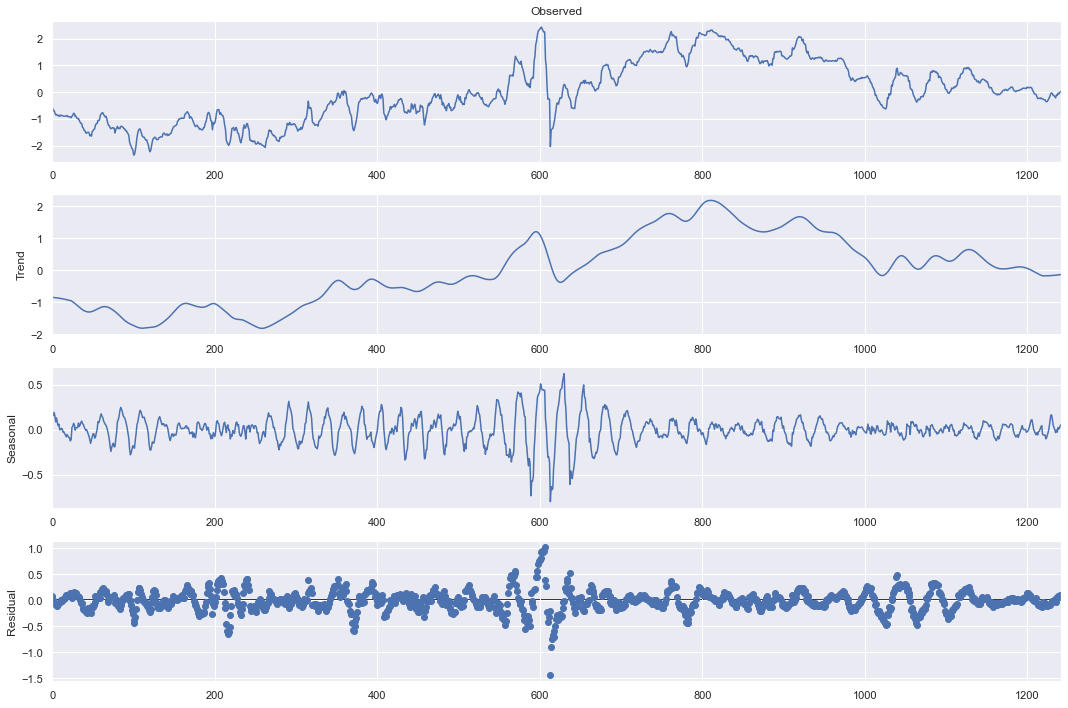

In [54]:
from statsmodels.tsa.seasonal import STL

plt.rcParams["figure.figsize"] = (15,10)

stl = STL(errors.to_numpy(), period=24)
res = stl.fit()
res.plot();

plt.rcParams["figure.figsize"] = (23,9)

In [55]:
seas_strength = max(0, 1 - res.resid.std()**2 / (res.resid.std()**2 + res.seasonal.std()**2))

seas_strength

0.36336014794416294

In [56]:
kpss(errors.diff().dropna())

C:\Users\Asus\anaconda4\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Asus\anaconda4\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.057925832912633014,
 0.1,
 23,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

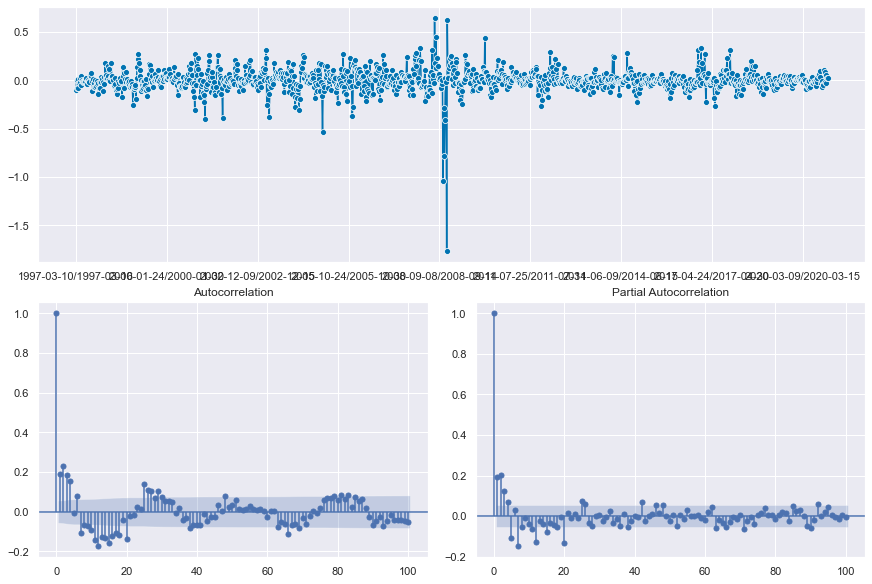

In [57]:
plot_correlations(errors.diff().dropna(),lags=100);

d=1

D=0

$p \leq 4$

$q \leq 4$

$P \leq 3$ (не очевидно)

$Q \leq 3$ 

### 3.4) Кросс-валидация (1.5 балла)

Отберите на кросс-валидации наилучшую модель. Для прогноза фичи на необходимые 4 шага используйте AutoARIMA. 



In [58]:
d, max_p, max_q, D, max_P, max_Q = 1, 4, 4, 0, 3, 3
orders = []
sp = 24
for p in range(max_p+1):
    for q in range(max_q+1):
        orders.append((p, d, q))

seasonal_orders = []

for P in range(max_P+1):
    for Q in range(max_Q+1):
        seasonal_orders.append((P, D, Q, sp))

In [59]:
fh = ForecastingHorizon(list(range(1, 4+1)))

cv = SlidingWindowSplitter(
    start_with_window=True,
    initial_window=150,
    fh=fh,
    step_length=15)

In [61]:
from numpy.linalg import LinAlgError

In [1]:
MAE = []
for i in orders:
    for j in seasonal_orders:
        mae_it = []
        for train_size, test_size in list(cv.split(df['target'])):
            y_train = df.y.iloc[train_size]
            y_val = df.y.iloc[test_size]
            X_train = df.gas1.iloc[train_size]
            X_val = df.gas1.iloc[test_size]
            try:
                sarima_x = ARIMA(order = i, 
                                 seasonal_order = j,
                                 suppress_warnings=True)
                sarima_x.fit(y_train,X_train)

                forecaster_x = AutoARIMA(suppress_warnings=True)
                forecaster_x.fit(X_train)
                X_pred = forecaster_x.predict(fh)
                pred = sarima_x.predict(fh, X_pred)
                mae_it.append(mae(y_val,pred))
            except LinAlgError as l:
                print('LinAlgError')
        MAE.append([i,j,np.mean(np.array(mae_it))])

LinAlgError
LinAlgError


In [70]:
res_mod2 = np.array(MAE)[np.argmin(np.array(MAE)[:,2])][2]

C:\Users\Asus\AppData\Local\Temp/ipykernel_9040/2150607113.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res_mod2 = np.array(MAE)[np.argmin(np.array(MAE)[:,2])][2]


### 3.5) Сравнение результатов (0.5 балла)

Добавьте к сравнению из пункта 2.4 лучшую модель из пункта 3.4. Получилось ли лучше?

In [71]:
# ༼ つ ◕_◕ ༽つ
print('Модель на кросс-валидации', res_val)
print('Модель AutoARIMA', res_auto)
print('Наивная модель', res_naive)
print('SARIMAX ',res_mod2)

Модель на кросс-валидации 0.14791587861959293
Модель AutoARIMA 0.16052459621234716
Наивная модель 0.10527144564076812
SARIMAX  0.16462976430882562


Увы, лучше не вышло